# **Setting Data Kaggle**

In [1]:
#install Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hendricoyehezky","key":"5e0f8e205c85eaf2fa1accc496ed0fa5"}'}

In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list -s 'covid 19 xray'

ref                                                                     title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/bachrr/covid-chest-xray                                        COVID-19 chest xray                             241MB  2020-05-15 00:30:50           9620        215  0.9411765        
datasets/khoongweihao/covid19-xray-dataset-train-test-sets              COVID-19 Xray Dataset (Train & Test Sets)        84MB  2020-03-19 01:49:56           4994        131  0.875            
datasets/fusicfenta/chest-xray-for-covid19-detection                    Chest Xray for covid-19 detection               176MB  2020-05-15 04:15:43            899         28  0.875            
datasets/alifrahman/covid19-chest-xray-i

In [11]:
!kaggle datasets download -d 'khoongweihao/covid19-xray-dataset-train-test-sets'

 96% 81.0M/84.3M [00:01<00:00, 55.4MB/s]
100% 84.3M/84.3M [00:01<00:00, 50.1MB/s]


In [12]:
!unzip /content/covid19-xray-dataset-train-test-sets.zip

Archive:  /content/covid19-xray-dataset-train-test-sets.zip
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0117-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL

# **Import Moduls**

In [32]:
%matplotlib inline
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.models import load_model
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

# **Preparing Data**

In [29]:
# Lokasi Data Train
DATA_PATH = '/content/xray_dataset_covid19/train'
COVID_PATH = '/content/xray_dataset_covid19/train/PNEUMONIA'
NORMAL_PATH = '/content/xray_dataset_covid19/train/NORMAL'

# **Pre-processing Data**

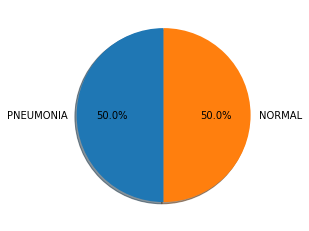

In [30]:
# Pengecekan Balancing Data
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(class_names)

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

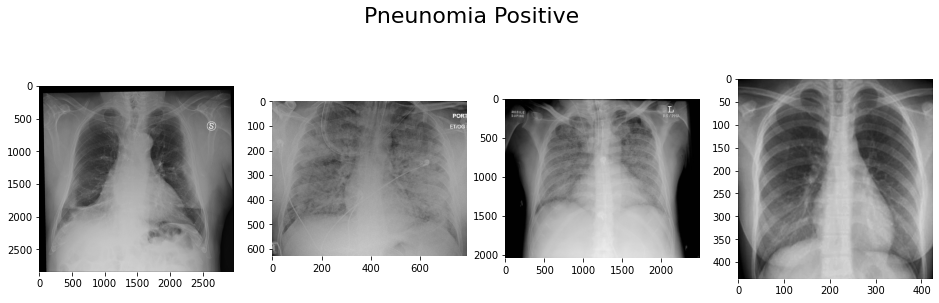

In [34]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneunomia Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

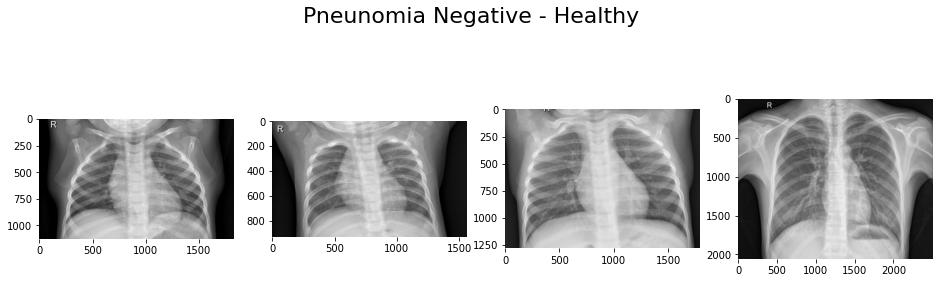

In [35]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneunomia Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [38]:
#Data Transform
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [39]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['NORMAL', 'PNEUMONIA']


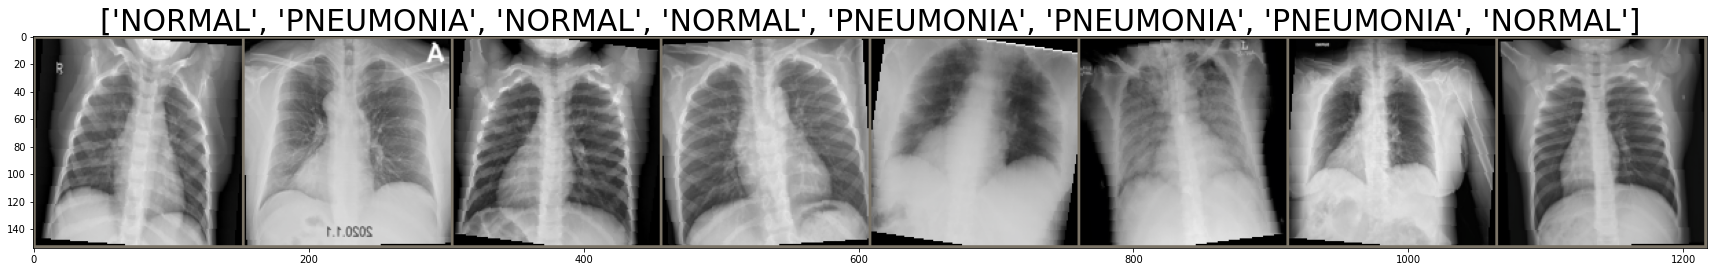

In [40]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **X-Net**

In [50]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning

    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to()
                labels = labels.to()

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [43]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to()
            labels = labels.to()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [51]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.3990 | train Accuracy: 0.8151


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0862 | val Accuracy: 0.9655 | Kappa Score: 0.9375
Val loss Decreased from inf to 0.0862 
Saving Weights... 

Epoch 2/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1118 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0408 | val Accuracy: 0.9655 | Kappa Score: 0.9375
Val loss Decreased from 0.0862 to 0.0408 
Saving Weights... 

Epoch 3/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.0852 | train Accuracy: 0.9580


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0397 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0408 to 0.0397 
Saving Weights... 

Epoch 4/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1441 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0407 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 5/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1564 | train Accuracy: 0.9580


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0377 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0397 to 0.0377 
Saving Weights... 

Epoch 6/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1679 | train Accuracy: 0.9244


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0370 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0377 to 0.0370 
Saving Weights... 

Epoch 7/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1212 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0339 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0370 to 0.0339 
Saving Weights... 

Epoch 8/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1024 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0364 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 9/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1140 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0381 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 10/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1807 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0418 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 11/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1298 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0366 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 12/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1351 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0505 | val Accuracy: 0.9655 | Kappa Score: 0.9000

Epoch 13/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1973 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0461 | val Accuracy: 0.9655 | Kappa Score: 0.9000

Epoch 14/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2386 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0351 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 15/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.2490 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0365 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 16/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1549 | train Accuracy: 0.9244


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0517 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 17/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1549 | train Accuracy: 0.9664


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0449 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 18/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1838 | train Accuracy: 0.9412


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0452 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 19/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1757 | train Accuracy: 0.9580


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0516 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Epoch 20/20
----------


train:   0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.1423 | train Accuracy: 0.9496


val:   0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.0489 | val Accuracy: 0.9655 | Kappa Score: 0.9375

Training complete in 6m 56s
Best val loss: 0.0339


# **Visualisasi Hasil Training**

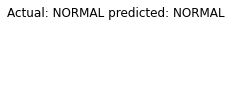

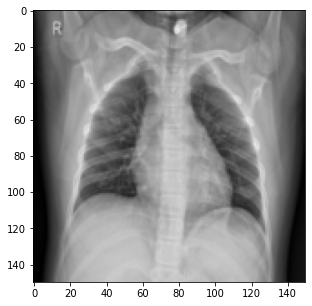

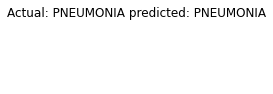

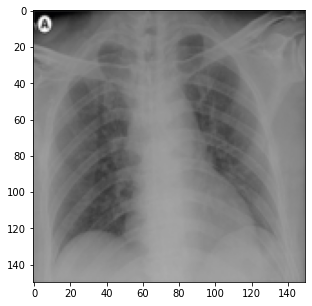

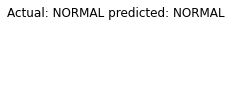

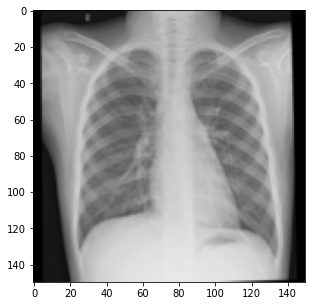

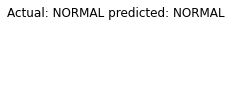

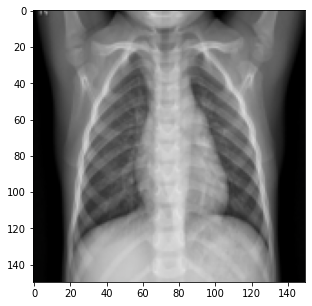

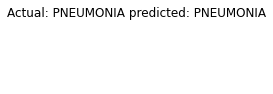

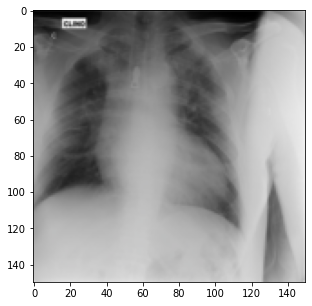

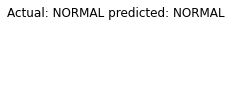

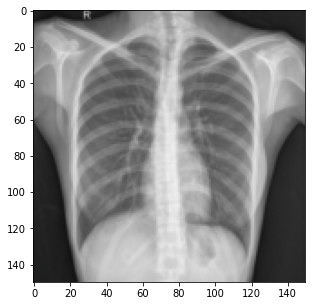

In [52]:
visualize_model(base_model)
plt.show()

# **Evaluasi Model X-Net**

In [53]:
os.makedirs('./content/xray_dataset_covid19/test/PNEUMONIA')
os.makedirs('./content/xray_dataset_covid19/test/NORMAL')

In [81]:
TEST_DATA_PATH = '/content/xray_dataset_covid19/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [55]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(), y_batch.to()
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [56]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [57]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [58]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

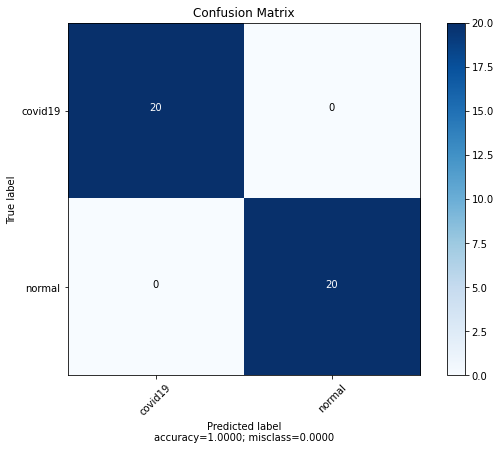

In [59]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [60]:
torch.save(base_model.state_dict(), './best_model.pth')

# **Inferensi (Simulasi Prediksi)**

In [61]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [62]:
import cv2
from torch.autograd import Variable

In [73]:
# Fungsi Inferensi
def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

Predicted: PNEUMONIA


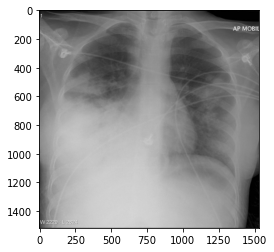

In [68]:
predict('/content/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg')

Predicted: PNEUMONIA


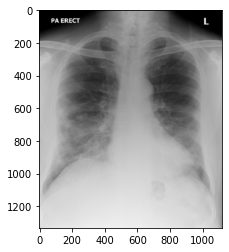

In [83]:
predict('/content/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg')